# Libraries

In [13]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision.models import vgg11
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Dataset Loader

In [3]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

def data_loader(batch_size, num_workers=0, random_seed=42, valid_size=0.1, shuffle=True, test=False):

    # Define augmentations
    transform_augmented1 = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616],
        )
    ])

    transform_augmented2 = transforms.Compose([
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616],
        )
    ])

    transform_augmented_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2470, 0.2435, 0.2616],
        )
    ])

    # Download CIFAR-10 dataset
    if test:
        dataset = datasets.CIFAR10(
            root='./data', train=False,
            download=True, transform=transform_augmented_test,
        )

        data_loader = torch.utils.data.DataLoader(
            dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers
        )

        return data_loader

    # Load the dataset
    train_dataset = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_augmented1)
    train_dataset2 = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_augmented2)

    valid_dataset = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_augmented1)
    valid_dataset2 = datasets.CIFAR10(
        root='./data', train=True, download=True, transform=transform_augmented2)


    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    # Save 10% of training data in a new variable train_loader_SI
    train_si_sampler = SubsetRandomSampler(indices[:int(0.1 * num_train)])
    train_loader_SI = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_si_sampler, num_workers=num_workers)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
    
    ######
    # Save 10% of training data in a new variable train_loader_SI2
    train_si_sampler2 = SubsetRandomSampler(indices[:int(0.1 * num_train)])
    train_loader_SI2 = torch.utils.data.DataLoader(
        train_dataset2, batch_size=batch_size, sampler=train_si_sampler2, num_workers=num_workers)

    train_loader2 = torch.utils.data.DataLoader(
        train_dataset2, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)

    valid_loader2 = torch.utils.data.DataLoader(
        valid_dataset2, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

    return (train_loader, valid_loader, train_loader_SI, train_loader2, valid_loader2, train_loader_SI2)

# Example usage
train_loader, valid_loader, train_loader_SI, train_loader2, valid_loader2, train_loader_SI2 = data_loader(batch_size=128, num_workers=1)
test_loader = data_loader(batch_size=128, test=True, num_workers=1)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Functions

In [4]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda'):
    # Define criterion, optimizer, and learning rate scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    # Initialize variables for tracking best accuracy and corresponding model weights
    best_val_acc = 0.0
    best_model_weights = None
    early_stopping_counter = 0

    # Lists to store metrics
    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    total_step = len(train_loader)

    for epoch in tqdm(range(num_epochs)):
        model.train()
        correct_train = 0
        total_train = 0
        running_loss = 0.0

        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()

            running_loss += loss.item()

        # Calculate and store training accuracy and loss
        epoch_train_accuracy = 100 * correct_train / total_train
        epoch_train_loss = running_loss / len(train_loader)
        train_acc_list.append(epoch_train_accuracy)
        train_loss_list.append(epoch_train_loss)

        # Step the learning rate scheduler
        scheduler.step()

        # Validation
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            val_loss = 0

            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

            # Calculate validation accuracy
            current_val_acc = 100 * correct / total

            # Store validation loss and accuracy
            val_loss_list.append(val_loss / len(valid_loader))
            val_acc_list.append(current_val_acc)

            # Check if the current accuracy is the best so far
            if current_val_acc > best_val_acc:
                best_val_acc = current_val_acc
                # Save the model weights
                best_model_weights = model.state_dict()
                # Reset early stopping counter
                early_stopping_counter = 0
            else:
                # Increment early stopping counter
                early_stopping_counter += 1

            # Check for early stopping
            if early_stopping_counter >= early_stopping_threshold:
                print(f'Early stopping after {early_stopping_counter} epochs without improvement.')
                break

        # Print and save metrics
        print('Epoch [{}/{}], Step [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%, Validation Loss: {:.4f}'
              .format(epoch + 1, num_epochs, i + 1, total_step, epoch_train_loss, epoch_train_accuracy, current_val_acc, val_loss_list[-1]))

    # Print test set accuracy on the best weights
    test_accuracy = test_model(model, test_loader, device)
    print(f'Test Set Accuracy on Best Weights: {test_accuracy:.2f}%')

    # Save the model with the best validation accuracy
    torch.save(best_model_weights, 'best_model_weights.pth')

    # Plot training and validation metrics
    plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list)

def test_model(model, test_loader, device='cuda'):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return test_accuracy

def plot_metrics(train_loss_list, val_loss_list, train_acc_list, val_acc_list):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [5]:
# Print the summary with information about frozen layers
def print_trainable_status(module, prefix=""):
    for name, child in module.named_children():
        for param in child.parameters():
            print(f"{prefix}{'.'.join([module._get_name(), name])}: requires_grad={param.requires_grad}")
        print_trainable_status(child, prefix + "  ")

In [15]:
!git clone https://github.com/Arhosseini77/data_complexity_measures

Cloning into 'data_complexity_measures'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done. (101/143)
remote: Compressing objects: 100% (130/130), done.
remote: Total 143 (delta 82), reused 33 (delta 9), pack-reused 0
Receiving objects: 100% (143/143), 144.63 KiB | 809.00 KiB/s, done.
Resolving deltas: 100% (82/82), done.


In [4]:
from data_complexity_measures.models.ARH_SeparationIndex import ARH_SeparationIndex

# First Layer

In [5]:
import torch.nn as nn

class VGG_first_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG_first_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Define device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Create model
model = VGG_first_layer()

# Move the model to the specified device
model.to(device)

VGG_first_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

  7%|▋         | 1/15 [00:42<09:59, 42.83s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.7036, Training Accuracy: 40.76%, Validation Accuracy: 46.60%, Validation Loss: 1.5150


 13%|█▎        | 2/15 [01:24<09:10, 42.35s/it]

Epoch [2/15], Step [352/352], Training Loss: 1.4031, Training Accuracy: 50.23%, Validation Accuracy: 51.08%, Validation Loss: 1.3832


 20%|██        | 3/15 [02:05<08:20, 41.68s/it]

Epoch [3/15], Step [352/352], Training Loss: 1.3190, Training Accuracy: 53.65%, Validation Accuracy: 53.82%, Validation Loss: 1.3244


 27%|██▋       | 4/15 [02:47<07:37, 41.63s/it]

Epoch [4/15], Step [352/352], Training Loss: 1.2558, Training Accuracy: 55.88%, Validation Accuracy: 56.60%, Validation Loss: 1.2330


 33%|███▎      | 5/15 [03:29<06:57, 41.77s/it]

Epoch [5/15], Step [352/352], Training Loss: 1.2056, Training Accuracy: 57.83%, Validation Accuracy: 56.86%, Validation Loss: 1.2275


 40%|████      | 6/15 [04:10<06:14, 41.58s/it]

Epoch [6/15], Step [352/352], Training Loss: 1.0908, Training Accuracy: 62.53%, Validation Accuracy: 61.56%, Validation Loss: 1.1251


 47%|████▋     | 7/15 [04:52<05:33, 41.74s/it]

Epoch [7/15], Step [352/352], Training Loss: 1.0660, Training Accuracy: 63.22%, Validation Accuracy: 62.22%, Validation Loss: 1.0926


 53%|█████▎    | 8/15 [05:33<04:51, 41.62s/it]

Epoch [8/15], Step [352/352], Training Loss: 1.0550, Training Accuracy: 63.52%, Validation Accuracy: 62.24%, Validation Loss: 1.1035


 60%|██████    | 9/15 [06:15<04:09, 41.56s/it]

Epoch [9/15], Step [352/352], Training Loss: 1.0506, Training Accuracy: 63.84%, Validation Accuracy: 63.32%, Validation Loss: 1.0958


 67%|██████▋   | 10/15 [06:56<03:26, 41.38s/it]

Epoch [10/15], Step [352/352], Training Loss: 1.0403, Training Accuracy: 64.15%, Validation Accuracy: 62.20%, Validation Loss: 1.0904


 73%|███████▎  | 11/15 [07:37<02:45, 41.30s/it]

Epoch [11/15], Step [352/352], Training Loss: 1.0253, Training Accuracy: 64.90%, Validation Accuracy: 62.52%, Validation Loss: 1.0735


 80%|████████  | 12/15 [08:18<02:03, 41.20s/it]

Epoch [12/15], Step [352/352], Training Loss: 1.0244, Training Accuracy: 64.96%, Validation Accuracy: 62.66%, Validation Loss: 1.0666


 87%|████████▋ | 13/15 [09:02<01:24, 42.01s/it]

Epoch [13/15], Step [352/352], Training Loss: 1.0197, Training Accuracy: 65.15%, Validation Accuracy: 63.00%, Validation Loss: 1.0761


 93%|█████████▎| 14/15 [09:43<00:41, 41.66s/it]

Epoch [14/15], Step [352/352], Training Loss: 1.0228, Training Accuracy: 64.81%, Validation Accuracy: 62.70%, Validation Loss: 1.0955


100%|██████████| 15/15 [10:24<00:00, 41.64s/it]

Epoch [15/15], Step [352/352], Training Loss: 1.0186, Training Accuracy: 65.11%, Validation Accuracy: 62.78%, Validation Loss: 1.0743


Test Set Accuracy on Best Weights: 65.39%


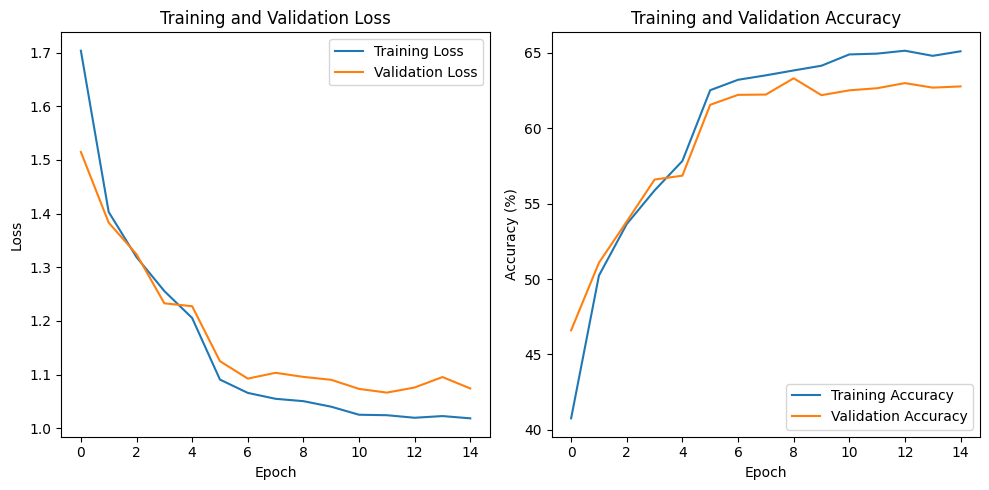

In [8]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Center SI first layer - train

In [6]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG_first_layer().to(device)
model.load_state_dict(torch.load('first_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

VGG_first_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [7]:
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

In [ ]:
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

In [13]:
csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2025.91it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1254.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3247.20it/s]


[('layer1', 0.3646666705608368), ('fc1', 0.6171111464500427), ('fc2', 0.5611110925674438)]


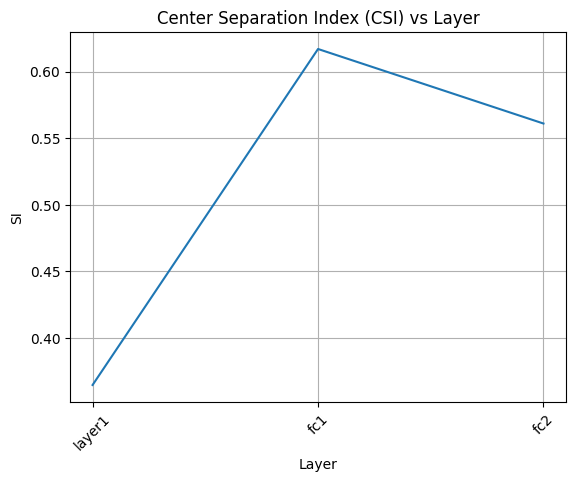

In [14]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# CSI first layer - test

In [9]:
from tqdm import tqdm

100%|██████████| 79/79 [00:01<00:00, 60.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3149.35it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4306.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4374.53it/s]


[('layer1', 0.39649999141693115), ('fc1', 0.6405999660491943), ('fc2', 0.5863999724388123)]


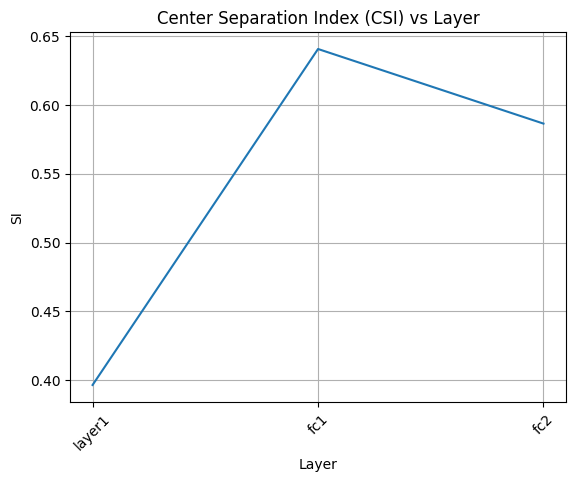

In [14]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG_first_layer().to(device)
model.load_state_dict(torch.load('first_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()
# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))
        
# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)     

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))
    
    
    
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()   

# Second Layer

In [15]:
import torch.nn as nn

class VGG11_second_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_second_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8192, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out


# Initialize your model
model = VGG11_second_layer().to(device)

model

VGG11_second_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=8192, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

  7%|▋         | 1/15 [00:47<10:58, 47.03s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.4459, Training Accuracy: 47.99%, Validation Accuracy: 55.84%, Validation Loss: 1.2534


 13%|█▎        | 2/15 [01:30<09:41, 44.70s/it]

Epoch [2/15], Step [352/352], Training Loss: 1.1711, Training Accuracy: 58.34%, Validation Accuracy: 59.68%, Validation Loss: 1.1342


 20%|██        | 3/15 [02:12<08:46, 43.86s/it]

Epoch [3/15], Step [352/352], Training Loss: 1.0759, Training Accuracy: 62.23%, Validation Accuracy: 64.22%, Validation Loss: 1.0100


 27%|██▋       | 4/15 [02:55<07:55, 43.19s/it]

Epoch [4/15], Step [352/352], Training Loss: 1.0088, Training Accuracy: 64.76%, Validation Accuracy: 62.14%, Validation Loss: 1.0410


 33%|███▎      | 5/15 [03:36<07:07, 42.70s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.9593, Training Accuracy: 66.63%, Validation Accuracy: 66.34%, Validation Loss: 0.9733


 40%|████      | 6/15 [04:19<06:23, 42.63s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.8204, Training Accuracy: 71.99%, Validation Accuracy: 70.54%, Validation Loss: 0.8441


 47%|████▋     | 7/15 [05:01<05:40, 42.50s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.7951, Training Accuracy: 72.70%, Validation Accuracy: 71.86%, Validation Loss: 0.8377


 53%|█████▎    | 8/15 [05:43<04:56, 42.36s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.7884, Training Accuracy: 72.92%, Validation Accuracy: 71.22%, Validation Loss: 0.8373


 60%|██████    | 9/15 [06:25<04:13, 42.30s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.7763, Training Accuracy: 73.34%, Validation Accuracy: 71.20%, Validation Loss: 0.8409


 67%|██████▋   | 10/15 [07:09<03:33, 42.80s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.7678, Training Accuracy: 73.75%, Validation Accuracy: 71.78%, Validation Loss: 0.8047


 73%|███████▎  | 11/15 [07:53<02:51, 42.92s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.7533, Training Accuracy: 74.28%, Validation Accuracy: 72.00%, Validation Loss: 0.8015


 80%|████████  | 12/15 [08:35<02:07, 42.64s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.7474, Training Accuracy: 74.36%, Validation Accuracy: 72.64%, Validation Loss: 0.7844


 87%|████████▋ | 13/15 [09:17<01:24, 42.45s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.7468, Training Accuracy: 74.43%, Validation Accuracy: 72.74%, Validation Loss: 0.7907


 93%|█████████▎| 14/15 [09:59<00:42, 42.33s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.7443, Training Accuracy: 74.46%, Validation Accuracy: 72.72%, Validation Loss: 0.7883


100%|██████████| 15/15 [10:41<00:00, 42.78s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.7464, Training Accuracy: 74.49%, Validation Accuracy: 72.74%, Validation Loss: 0.7834


Test Set Accuracy on Best Weights: 74.69%


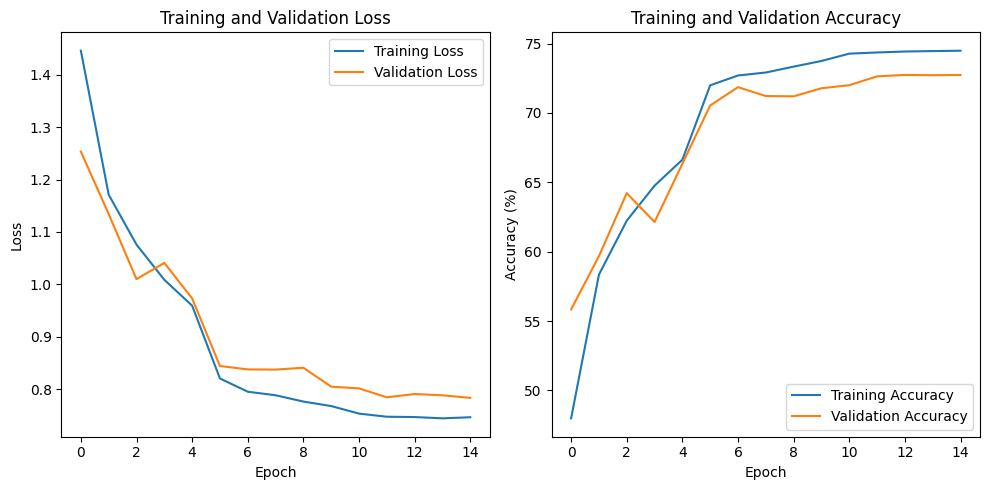

In [10]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Center SI second layer - train

100%|██████████| 40/40 [00:02<00:00, 17.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1963.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2725.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2954.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3199.32it/s]

[('layer1', 0.4023999869823456), ('layer2', 0.503600001335144), ('fc1', 0.7107999920845032), ('fc2', 0.6665999889373779)]


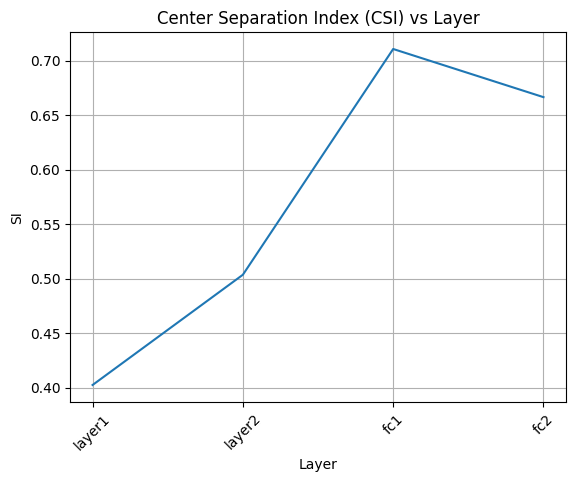

In [17]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_second_layer().to(device)
model.load_state_dict(torch.load('second_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4023999869823456), ('layer2', 0.503600001335144), ('fc1', 0.7107999920845032), ('fc2', 0.6665999889373779)]


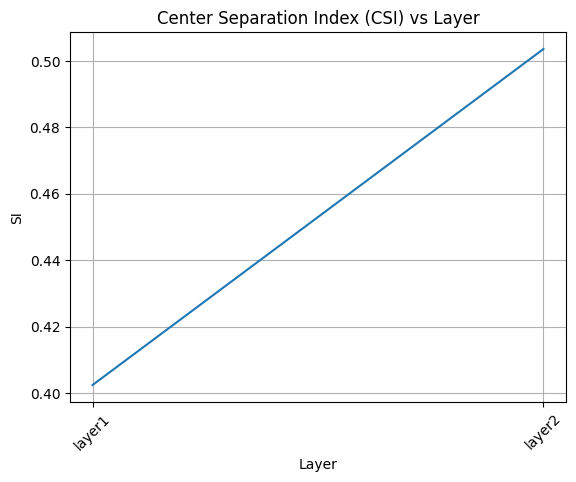

In [18]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Center SI second layer - test

100%|██████████| 79/79 [00:01<00:00, 58.18it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2975.95it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4070.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4018.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4076.89it/s]

[('layer1', 0.4154999852180481), ('layer2', 0.513700008392334), ('fc1', 0.7318999767303467), ('fc2', 0.6864999532699585)]


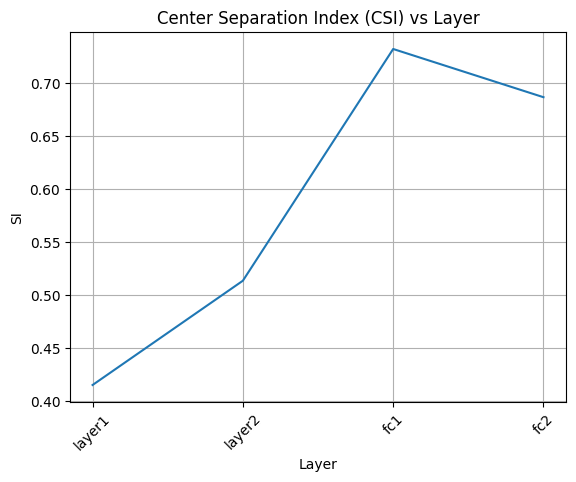

In [19]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_second_layer().to(device)
model.load_state_dict(torch.load('second_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4154999852180481), ('layer2', 0.513700008392334), ('fc1', 0.7318999767303467), ('fc2', 0.6864999532699585)]


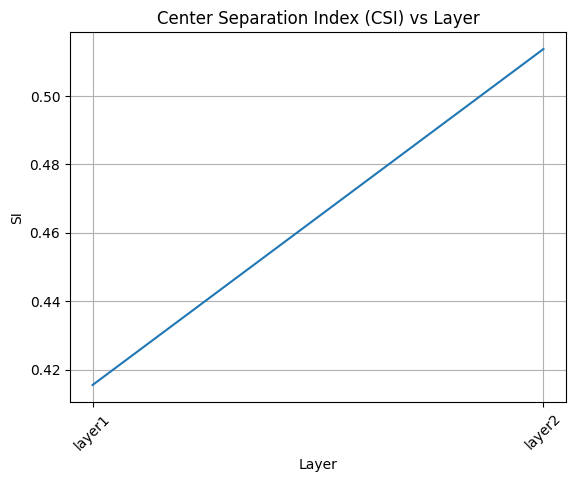

In [20]:
print(csi_layer_train)

# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Third Layer

In [21]:
import torch.nn as nn

class VGG11_third_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_third_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [22]:
model = VGG11_third_layer().to(device)
model

VGG11_third_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
  )
)

  7%|▋         | 1/15 [00:42<09:49, 42.08s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3534, Training Accuracy: 51.74%, Validation Accuracy: 54.28%, Validation Loss: 1.2711


 13%|█▎        | 2/15 [01:23<09:00, 41.57s/it]

Epoch [2/15], Step [352/352], Training Loss: 1.0347, Training Accuracy: 63.51%, Validation Accuracy: 60.64%, Validation Loss: 1.1266


 20%|██        | 3/15 [02:04<08:15, 41.32s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.9183, Training Accuracy: 67.74%, Validation Accuracy: 70.16%, Validation Loss: 0.8519


 27%|██▋       | 4/15 [02:45<07:34, 41.33s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.8410, Training Accuracy: 70.46%, Validation Accuracy: 69.32%, Validation Loss: 0.8958


 33%|███▎      | 5/15 [03:28<06:57, 41.74s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.7718, Training Accuracy: 72.87%, Validation Accuracy: 70.96%, Validation Loss: 0.8487


 40%|████      | 6/15 [04:09<06:15, 41.73s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.6164, Training Accuracy: 78.82%, Validation Accuracy: 77.38%, Validation Loss: 0.6671


 47%|████▋     | 7/15 [04:51<05:33, 41.73s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.5809, Training Accuracy: 79.88%, Validation Accuracy: 77.78%, Validation Loss: 0.6639


 53%|█████▎    | 8/15 [05:33<04:52, 41.84s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.5653, Training Accuracy: 80.48%, Validation Accuracy: 78.12%, Validation Loss: 0.6505


 60%|██████    | 9/15 [06:15<04:10, 41.78s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.5503, Training Accuracy: 81.06%, Validation Accuracy: 77.54%, Validation Loss: 0.6349


 67%|██████▋   | 10/15 [06:57<03:29, 41.91s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.5418, Training Accuracy: 81.18%, Validation Accuracy: 78.02%, Validation Loss: 0.6449


 73%|███████▎  | 11/15 [07:39<02:47, 41.88s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.5201, Training Accuracy: 82.14%, Validation Accuracy: 78.70%, Validation Loss: 0.6255


 80%|████████  | 12/15 [08:20<02:05, 41.76s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.5176, Training Accuracy: 82.20%, Validation Accuracy: 78.74%, Validation Loss: 0.6158


 87%|████████▋ | 13/15 [09:02<01:23, 41.71s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.5115, Training Accuracy: 82.39%, Validation Accuracy: 78.92%, Validation Loss: 0.5968


 93%|█████████▎| 14/15 [09:44<00:41, 41.72s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.5127, Training Accuracy: 82.30%, Validation Accuracy: 79.32%, Validation Loss: 0.5984


100%|██████████| 15/15 [10:28<00:00, 41.88s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.5058, Training Accuracy: 82.68%, Validation Accuracy: 78.98%, Validation Loss: 0.6122


Test Set Accuracy on Best Weights: 80.40%


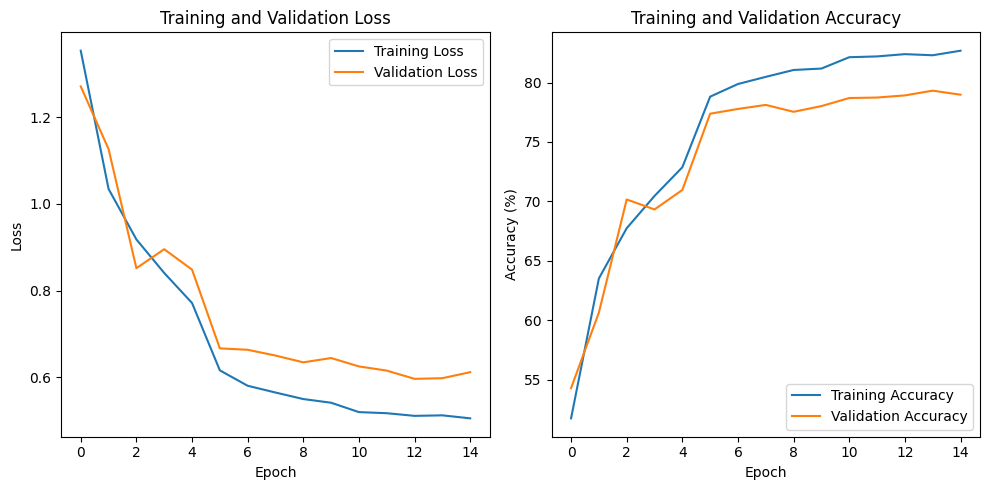

In [8]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Center SI third layer - train

100%|██████████| 40/40 [00:02<00:00, 17.01it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2015.85it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2001.10it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3143.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3249.72it/s]


[('layer1', 0.4047999978065491), ('layer2', 0.5076000094413757), ('layer3', 0.6061999797821045), ('fc1', 0.777999997138977), ('fc2', 0.7414000034332275)]


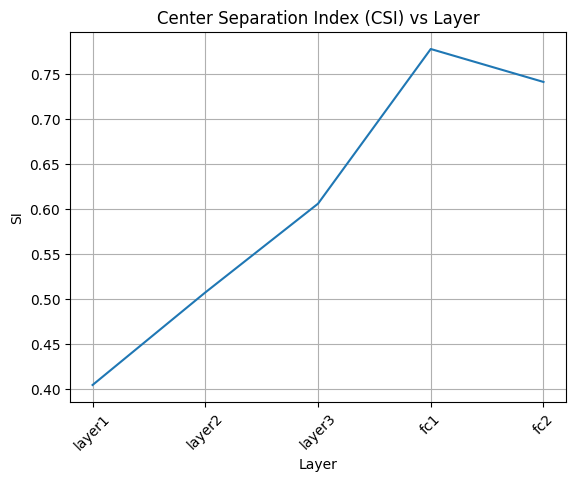

In [23]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_third_layer().to(device)
model.load_state_dict(torch.load('third_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4047999978065491), ('layer2', 0.5076000094413757), ('layer3', 0.6061999797821045), ('fc1', 0.777999997138977), ('fc2', 0.7414000034332275)]


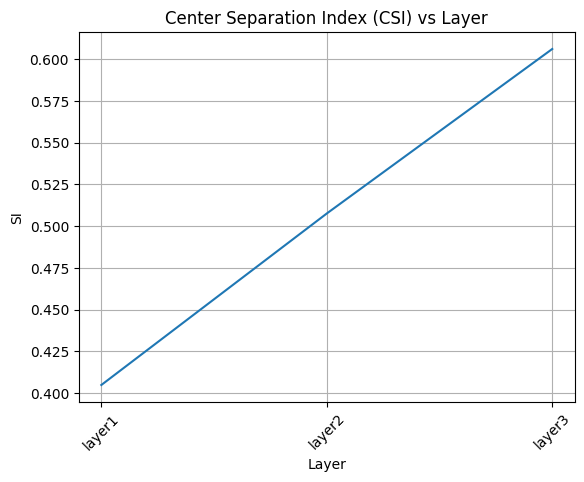

In [24]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Center SI third layer - test

100%|██████████| 79/79 [00:01<00:00, 57.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2894.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4078.48it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2951.66it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4038.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4412.27it/s]


[('layer1', 0.4205999970436096), ('layer2', 0.5223999619483948), ('layer3', 0.616100013256073), ('fc1', 0.7882999777793884), ('fc2', 0.7497999668121338)]


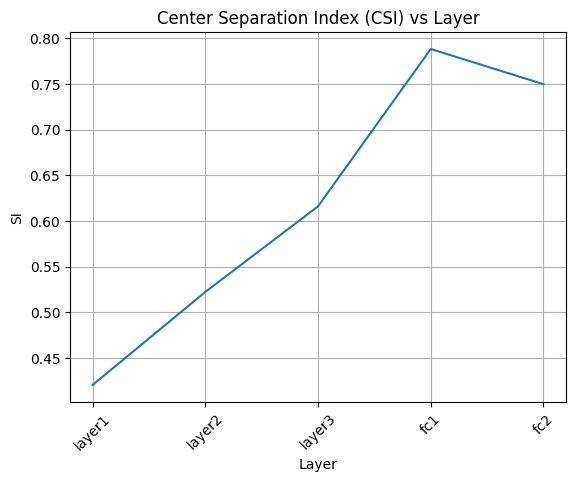

In [25]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_third_layer().to(device)
model.load_state_dict(torch.load('third_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4205999970436096), ('layer2', 0.5223999619483948), ('layer3', 0.616100013256073), ('fc1', 0.7882999777793884), ('fc2', 0.7497999668121338)]


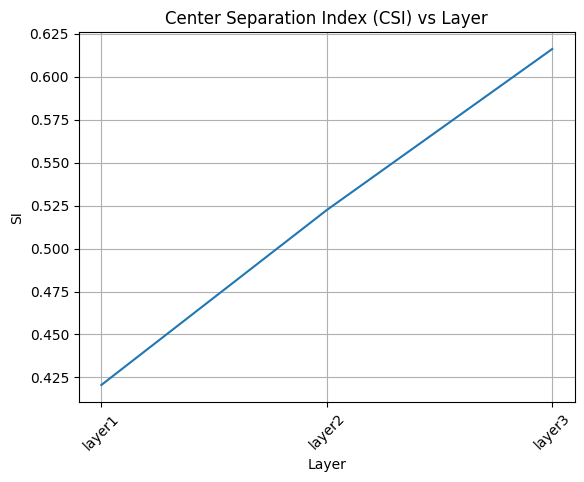

In [26]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fourth Layer

In [27]:
import torch.nn as nn

class VGG11_Fourth_Layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_Fourth_Layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [28]:
import torch
import torch.nn as nn

# Initialize your model
model = VGG11_Fourth_Layer().to(device)

model

VGG11_Fourth_Layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

  7%|▋         | 1/15 [00:44<10:18, 44.15s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.3419, Training Accuracy: 51.77%, Validation Accuracy: 51.26%, Validation Loss: 1.3721


 13%|█▎        | 2/15 [01:25<09:16, 42.80s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9924, Training Accuracy: 64.94%, Validation Accuracy: 65.36%, Validation Loss: 0.9806


 20%|██        | 3/15 [02:07<08:24, 42.06s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.8574, Training Accuracy: 69.94%, Validation Accuracy: 70.86%, Validation Loss: 0.8360


 27%|██▋       | 4/15 [02:48<07:37, 41.57s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.7723, Training Accuracy: 73.08%, Validation Accuracy: 70.82%, Validation Loss: 0.8354


 33%|███▎      | 5/15 [03:28<06:53, 41.36s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.7042, Training Accuracy: 75.20%, Validation Accuracy: 71.98%, Validation Loss: 0.8155


 40%|████      | 6/15 [04:09<06:10, 41.14s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.5470, Training Accuracy: 81.18%, Validation Accuracy: 79.06%, Validation Loss: 0.6192


 47%|████▋     | 7/15 [04:51<05:29, 41.21s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.5097, Training Accuracy: 82.36%, Validation Accuracy: 80.18%, Validation Loss: 0.6090


 53%|█████▎    | 8/15 [05:31<04:47, 41.08s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.4910, Training Accuracy: 82.99%, Validation Accuracy: 80.44%, Validation Loss: 0.5838


 60%|██████    | 9/15 [06:13<04:06, 41.12s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.4789, Training Accuracy: 83.34%, Validation Accuracy: 80.00%, Validation Loss: 0.5675


 67%|██████▋   | 10/15 [06:53<03:25, 41.06s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.4625, Training Accuracy: 84.08%, Validation Accuracy: 80.92%, Validation Loss: 0.5634


 73%|███████▎  | 11/15 [07:34<02:43, 40.90s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.4398, Training Accuracy: 84.81%, Validation Accuracy: 81.40%, Validation Loss: 0.5453


 80%|████████  | 12/15 [08:15<02:03, 41.01s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.4385, Training Accuracy: 84.85%, Validation Accuracy: 81.16%, Validation Loss: 0.5397


 87%|████████▋ | 13/15 [08:56<01:21, 40.89s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.4384, Training Accuracy: 84.79%, Validation Accuracy: 81.34%, Validation Loss: 0.5410


 93%|█████████▎| 14/15 [09:37<00:41, 41.05s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.4316, Training Accuracy: 84.94%, Validation Accuracy: 81.42%, Validation Loss: 0.5424


100%|██████████| 15/15 [10:18<00:00, 41.24s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.4295, Training Accuracy: 85.10%, Validation Accuracy: 82.16%, Validation Loss: 0.5363


Test Set Accuracy on Best Weights: 82.81%


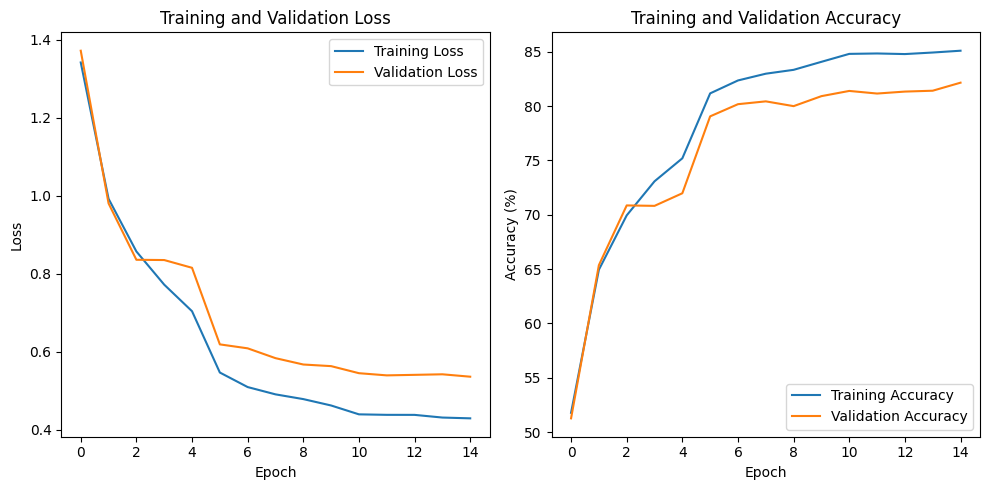

In [11]:
train_and_validate(model, train_loader, valid_loader, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Forth Layer CSI - train

100%|██████████| 40/40 [00:02<00:00, 17.99it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2164.24it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2839.10it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2074.33it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2923.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3203.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3116.90it/s]

[('layer1', 0.39819997549057007), ('layer2', 0.4909999966621399), ('layer3', 0.5759999752044678), ('layer4', 0.6523999571800232), ('fc1', 0.7971999645233154), ('fc2', 0.76419997215271)]


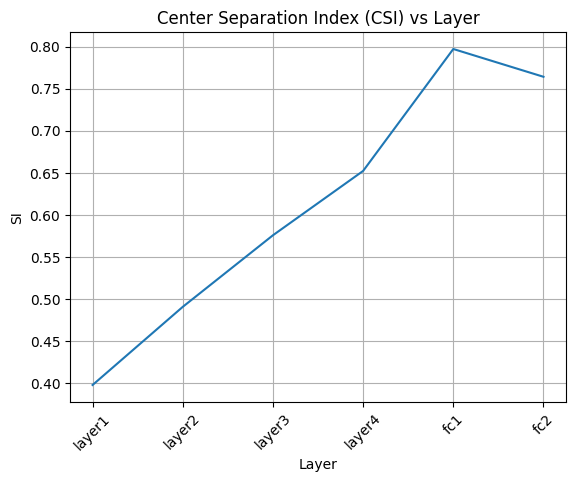

In [29]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_Fourth_Layer().to(device)
model.load_state_dict(torch.load('fourth_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.39819997549057007), ('layer2', 0.4909999966621399), ('layer3', 0.5759999752044678), ('layer4', 0.6523999571800232), ('fc1', 0.7971999645233154), ('fc2', 0.76419997215271)]


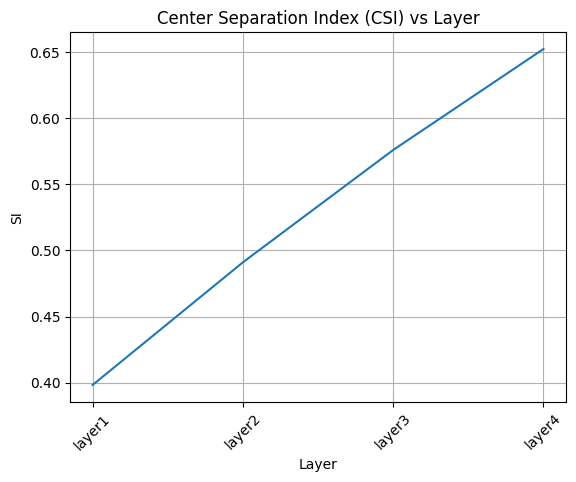

In [30]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Forth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 56.59it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3021.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4141.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2960.82it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3977.15it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3952.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3895.16it/s]

[('layer1', 0.41429999470710754), ('layer2', 0.5051000118255615), ('layer3', 0.5913000106811523), ('layer4', 0.6697999835014343), ('fc1', 0.8138999938964844), ('fc2', 0.7838000059127808)]


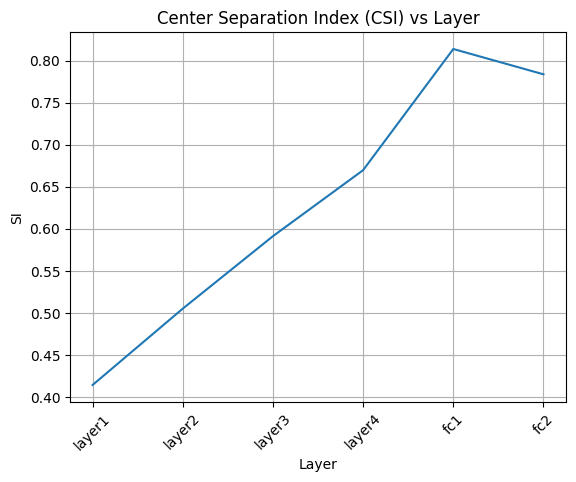

[('layer1', 0.41429999470710754), ('layer2', 0.5051000118255615), ('layer3', 0.5913000106811523), ('layer4', 0.6697999835014343), ('fc1', 0.8138999938964844), ('fc2', 0.7838000059127808)]


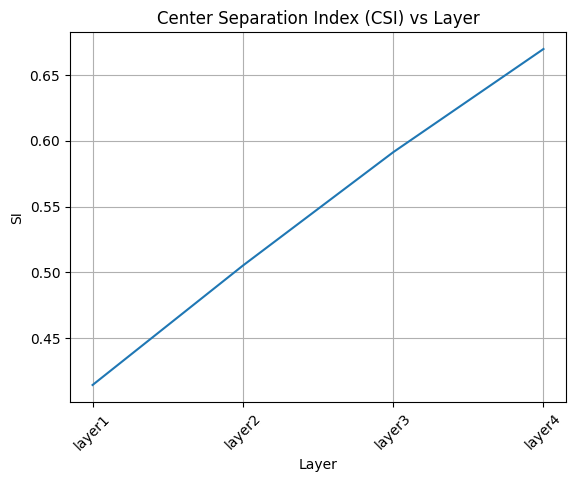

In [31]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_Fourth_Layer().to(device)
model.load_state_dict(torch.load('fourth_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()  

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fifth Layer

In [32]:
import torch.nn as nn

class VGG11_fifth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_fifth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [33]:
import torch
import torch.nn as nn

model = VGG11_fifth_layer().to(device)

model

VGG11_fifth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

  7%|▋         | 1/15 [00:22<05:13, 22.36s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.2566, Training Accuracy: 54.94%, Validation Accuracy: 59.26%, Validation Loss: 1.1457


 13%|█▎        | 2/15 [00:46<05:01, 23.17s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.8813, Training Accuracy: 68.78%, Validation Accuracy: 65.18%, Validation Loss: 1.0322


 20%|██        | 3/15 [01:09<04:37, 23.10s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7411, Training Accuracy: 74.04%, Validation Accuracy: 72.30%, Validation Loss: 0.7724


 27%|██▋       | 4/15 [01:31<04:12, 22.93s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6482, Training Accuracy: 77.36%, Validation Accuracy: 75.06%, Validation Loss: 0.7183


 33%|███▎      | 5/15 [01:54<03:48, 22.84s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.5656, Training Accuracy: 80.14%, Validation Accuracy: 76.66%, Validation Loss: 0.6754


 40%|████      | 6/15 [02:16<03:24, 22.73s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.3606, Training Accuracy: 87.85%, Validation Accuracy: 81.94%, Validation Loss: 0.5264


 47%|████▋     | 7/15 [02:38<02:59, 22.49s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.3066, Training Accuracy: 89.64%, Validation Accuracy: 81.76%, Validation Loss: 0.5288


 53%|█████▎    | 8/15 [03:02<02:38, 22.68s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.2780, Training Accuracy: 90.68%, Validation Accuracy: 82.00%, Validation Loss: 0.5313


 60%|██████    | 9/15 [03:24<02:16, 22.76s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.2551, Training Accuracy: 91.53%, Validation Accuracy: 81.68%, Validation Loss: 0.5070


 67%|██████▋   | 10/15 [03:47<01:52, 22.56s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.2342, Training Accuracy: 92.06%, Validation Accuracy: 82.12%, Validation Loss: 0.5548


 73%|███████▎  | 11/15 [04:09<01:29, 22.46s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.2047, Training Accuracy: 93.30%, Validation Accuracy: 82.82%, Validation Loss: 0.5481


 80%|████████  | 12/15 [04:32<01:07, 22.54s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.2018, Training Accuracy: 93.57%, Validation Accuracy: 82.24%, Validation Loss: 0.5365


 87%|████████▋ | 13/15 [04:54<00:45, 22.60s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.1986, Training Accuracy: 93.65%, Validation Accuracy: 83.32%, Validation Loss: 0.5041


 93%|█████████▎| 14/15 [05:16<00:22, 22.31s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.1959, Training Accuracy: 93.68%, Validation Accuracy: 82.70%, Validation Loss: 0.5253


100%|██████████| 15/15 [05:39<00:00, 22.61s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.1921, Training Accuracy: 93.97%, Validation Accuracy: 82.74%, Validation Loss: 0.5078


Test Set Accuracy on Best Weights: 83.92%


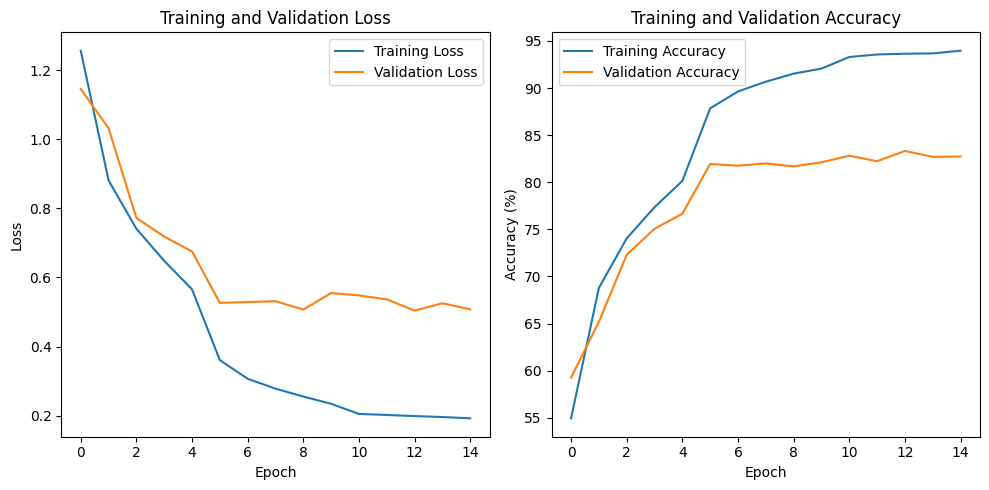

In [14]:
train_and_validate(model, train_loader2, valid_loader2, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Fifth Layer CSI - train

100%|██████████| 40/40 [00:00<00:00, 41.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2029.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2964.17it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2160.90it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3002.37it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2955.82it/s]

Data has been normalized



Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3029.11it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3008.83it/s]


[('layer1', 0.4123999774456024), ('layer2', 0.4941999912261963), ('layer3', 0.5763999819755554), ('layer4', 0.6431999802589417), ('layer5', 0.7265999913215637), ('fc1', 0.8068000078201294), ('fc2', 0.7897999882698059)]


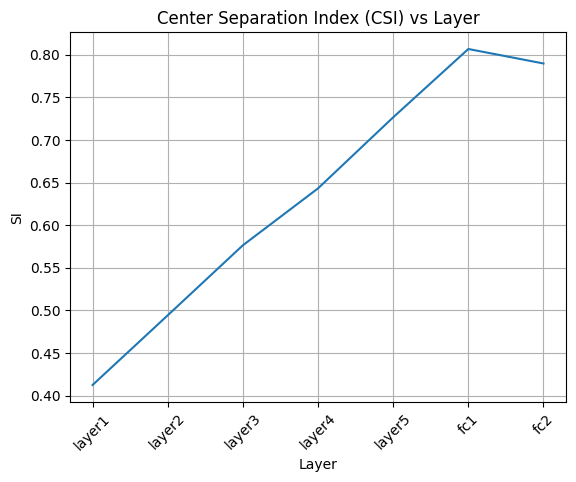

In [34]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_fifth_layer().to(device)
model.load_state_dict(torch.load('fifth_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI2): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.4123999774456024), ('layer2', 0.4941999912261963), ('layer3', 0.5763999819755554), ('layer4', 0.6431999802589417), ('layer5', 0.7265999913215637), ('fc1', 0.8068000078201294), ('fc2', 0.7897999882698059)]


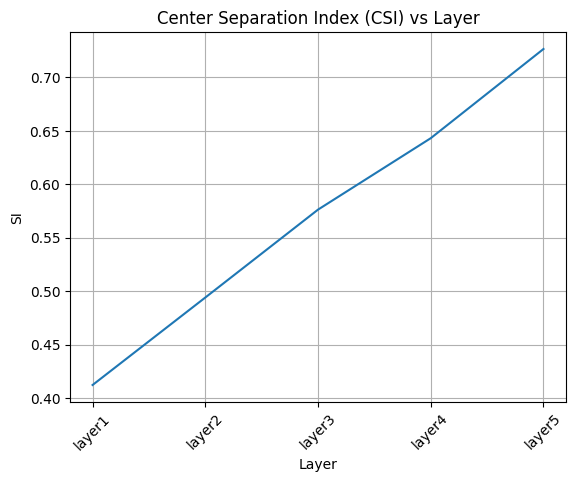

In [35]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Fifth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 57.66it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4136.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4223.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4081.65it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4050.12it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4501.29it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4230.69it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4162.67it/s]

[('layer1', 0.41349998116493225), ('layer2', 0.5012999773025513), ('layer3', 0.5837999582290649), ('layer4', 0.6575999855995178), ('layer5', 0.7350999712944031), ('fc1', 0.8245999813079834), ('fc2', 0.8003000020980835)]


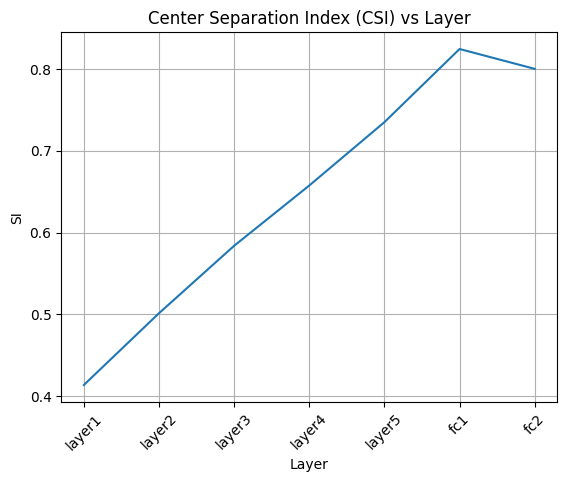

In [36]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_fifth_layer().to(device)
model.load_state_dict(torch.load('fifth_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

[('layer1', 0.41349998116493225), ('layer2', 0.5012999773025513), ('layer3', 0.5837999582290649), ('layer4', 0.6575999855995178), ('layer5', 0.7350999712944031), ('fc1', 0.8245999813079834), ('fc2', 0.8003000020980835)]


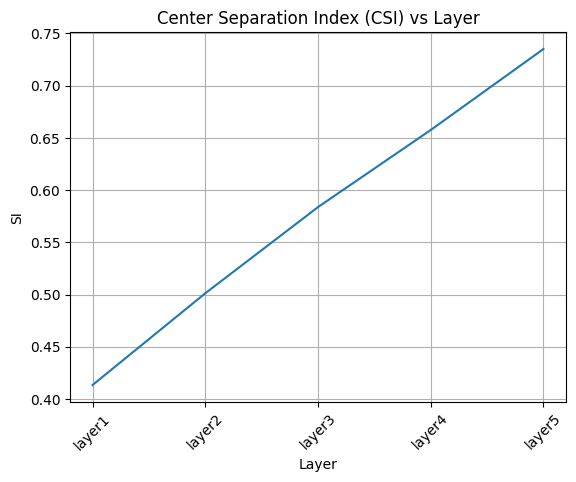

In [37]:
print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Sixth Layer

In [38]:
import torch.nn as nn

class VGG11_sixth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_sixth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 2* 2, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [39]:
import torch
import torch.nn as nn

model = VGG11_sixth_layer().to(device)
model

VGG11_sixth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

  7%|▋         | 1/15 [00:21<05:07, 21.99s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.2826, Training Accuracy: 53.53%, Validation Accuracy: 59.42%, Validation Loss: 1.1666


 13%|█▎        | 2/15 [00:44<04:49, 22.31s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.8909, Training Accuracy: 68.37%, Validation Accuracy: 66.44%, Validation Loss: 0.9845


 20%|██        | 3/15 [01:06<04:28, 22.36s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7302, Training Accuracy: 74.28%, Validation Accuracy: 70.70%, Validation Loss: 0.8240


 27%|██▋       | 4/15 [01:29<04:07, 22.50s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6260, Training Accuracy: 78.07%, Validation Accuracy: 70.58%, Validation Loss: 0.8803


 33%|███▎      | 5/15 [01:51<03:42, 22.25s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.5472, Training Accuracy: 80.85%, Validation Accuracy: 77.20%, Validation Loss: 0.6513


 40%|████      | 6/15 [02:14<03:21, 22.38s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.3259, Training Accuracy: 89.01%, Validation Accuracy: 82.42%, Validation Loss: 0.5283


 47%|████▋     | 7/15 [02:36<02:59, 22.43s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.2737, Training Accuracy: 90.73%, Validation Accuracy: 82.74%, Validation Loss: 0.5147


 53%|█████▎    | 8/15 [02:58<02:35, 22.21s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.2438, Training Accuracy: 91.85%, Validation Accuracy: 82.42%, Validation Loss: 0.5068


 60%|██████    | 9/15 [03:21<02:14, 22.37s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.2157, Training Accuracy: 92.89%, Validation Accuracy: 82.94%, Validation Loss: 0.5191


 67%|██████▋   | 10/15 [03:43<01:52, 22.49s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.1953, Training Accuracy: 93.51%, Validation Accuracy: 82.74%, Validation Loss: 0.5337


 73%|███████▎  | 11/15 [04:06<01:30, 22.54s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.1611, Training Accuracy: 95.02%, Validation Accuracy: 83.08%, Validation Loss: 0.5003


 80%|████████  | 12/15 [04:28<01:07, 22.40s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.1549, Training Accuracy: 95.21%, Validation Accuracy: 83.40%, Validation Loss: 0.5117


 87%|████████▋ | 13/15 [04:50<00:44, 22.39s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.1541, Training Accuracy: 95.23%, Validation Accuracy: 83.42%, Validation Loss: 0.5044


 93%|█████████▎| 14/15 [05:13<00:22, 22.43s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.1501, Training Accuracy: 95.32%, Validation Accuracy: 83.64%, Validation Loss: 0.5098


100%|██████████| 15/15 [05:35<00:00, 22.35s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.1476, Training Accuracy: 95.53%, Validation Accuracy: 83.24%, Validation Loss: 0.5280


Test Set Accuracy on Best Weights: 84.92%


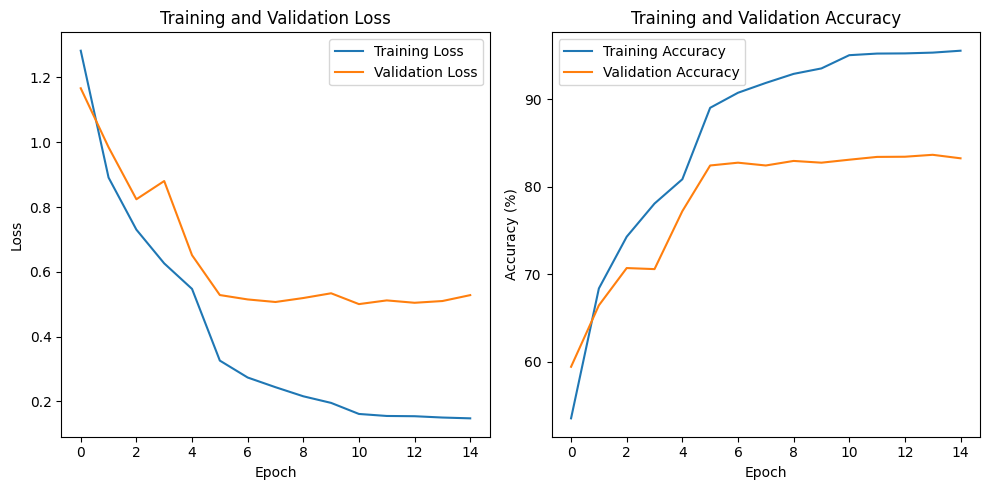

In [17]:
train_and_validate(model, train_loader2, valid_loader2, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Sixth Layer CSI - train

100%|██████████| 40/40 [00:00<00:00, 40.86it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3086.32it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2966.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1928.42it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3119.99it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3044.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2657.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3175.90it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3119.21it/s]

[('layer1', 0.41819998621940613), ('layer2', 0.5026000142097473), ('layer3', 0.5697999596595764), ('layer4', 0.6337999701499939), ('layer5', 0.7075999975204468), ('layer6', 0.776199996471405), ('fc1', 0.8273999691009521), ('fc2', 0.8091999888420105)]


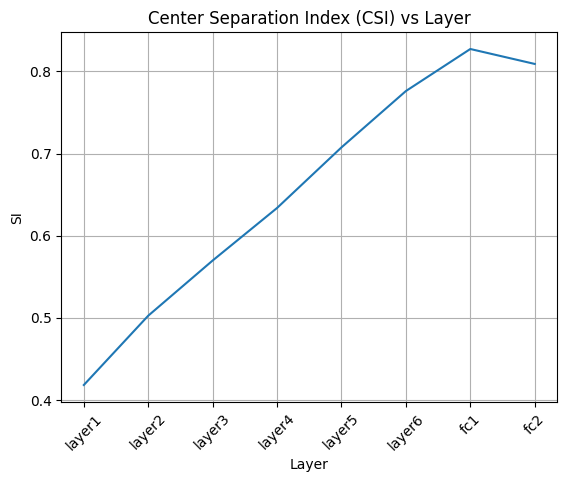

[('layer1', 0.41819998621940613), ('layer2', 0.5026000142097473), ('layer3', 0.5697999596595764), ('layer4', 0.6337999701499939), ('layer5', 0.7075999975204468), ('layer6', 0.776199996471405), ('fc1', 0.8273999691009521), ('fc2', 0.8091999888420105)]


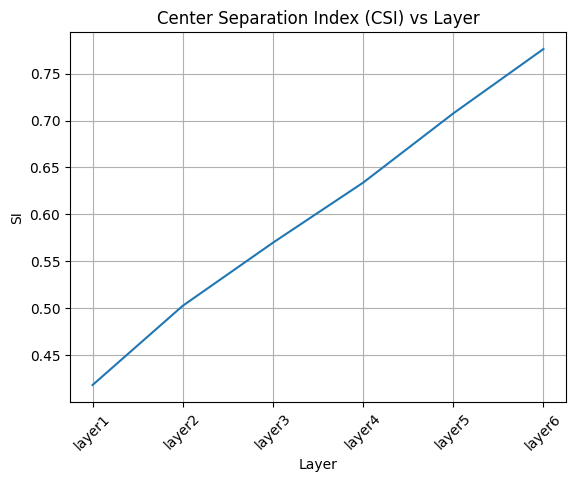

In [40]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_sixth_layer().to(device)
model.load_state_dict(torch.load('sixth_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI2): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    


print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Sixth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 56.69it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3944.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4161.02it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3982.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3902.40it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2877.94it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4019.84it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3996.10it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4474.40it/s]


[('layer1', 0.41359999775886536), ('layer2', 0.5101000070571899), ('layer3', 0.5819999575614929), ('layer4', 0.6504999995231628), ('layer5', 0.7287999987602234), ('layer6', 0.7831000089645386), ('fc1', 0.8324999809265137), ('fc2', 0.8138999938964844)]


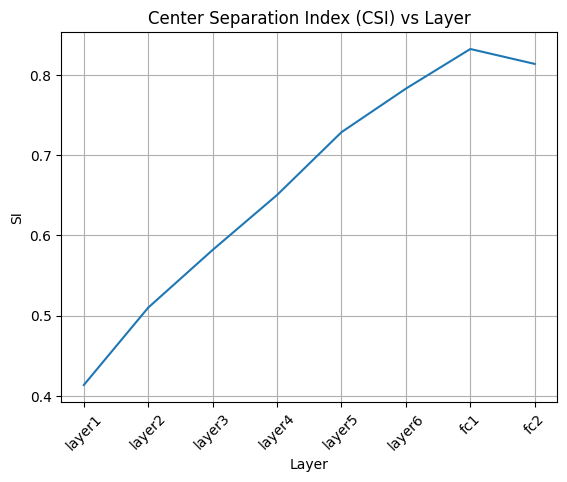

[('layer1', 0.41359999775886536), ('layer2', 0.5101000070571899), ('layer3', 0.5819999575614929), ('layer4', 0.6504999995231628), ('layer5', 0.7287999987602234), ('layer6', 0.7831000089645386), ('fc1', 0.8324999809265137), ('fc2', 0.8138999938964844)]


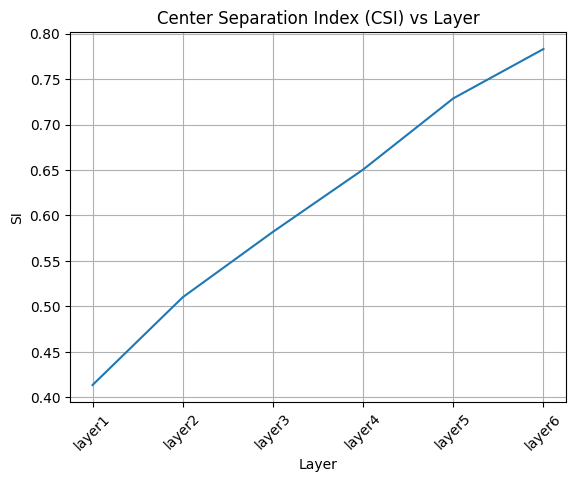

In [41]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_sixth_layer().to(device)
model.load_state_dict(torch.load('sixth_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    


print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# seventh Layer

In [42]:
import torch.nn as nn

class VGG11_seven_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_seven_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512 * 2 * 2, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [43]:
import torch
import torch.nn as nn

model = VGG11_seven_layer().to(device)

model

VGG11_seven_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

  7%|▋         | 1/15 [00:22<05:11, 22.22s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.2945, Training Accuracy: 52.83%, Validation Accuracy: 62.06%, Validation Loss: 1.0584


 13%|█▎        | 2/15 [00:45<04:53, 22.57s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.8960, Training Accuracy: 68.43%, Validation Accuracy: 66.60%, Validation Loss: 0.9487


 20%|██        | 3/15 [01:07<04:30, 22.56s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7307, Training Accuracy: 74.37%, Validation Accuracy: 73.32%, Validation Loss: 0.7687


 27%|██▋       | 4/15 [01:30<04:07, 22.52s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6160, Training Accuracy: 78.32%, Validation Accuracy: 72.78%, Validation Loss: 0.7806


 33%|███▎      | 5/15 [01:52<03:43, 22.35s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.5353, Training Accuracy: 81.13%, Validation Accuracy: 75.92%, Validation Loss: 0.6974


 40%|████      | 6/15 [02:15<03:23, 22.56s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.3208, Training Accuracy: 89.11%, Validation Accuracy: 82.14%, Validation Loss: 0.5378


 47%|████▋     | 7/15 [02:37<03:00, 22.60s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.2593, Training Accuracy: 91.22%, Validation Accuracy: 82.84%, Validation Loss: 0.5213


 53%|█████▎    | 8/15 [02:59<02:36, 22.32s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.2221, Training Accuracy: 92.67%, Validation Accuracy: 82.30%, Validation Loss: 0.5256


 60%|██████    | 9/15 [03:22<02:15, 22.57s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.1931, Training Accuracy: 93.48%, Validation Accuracy: 81.82%, Validation Loss: 0.5518


 67%|██████▋   | 10/15 [03:45<01:53, 22.68s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.1693, Training Accuracy: 94.40%, Validation Accuracy: 82.34%, Validation Loss: 0.5740


 73%|███████▎  | 11/15 [04:08<01:30, 22.75s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.1350, Training Accuracy: 95.74%, Validation Accuracy: 82.78%, Validation Loss: 0.5290


 80%|████████  | 12/15 [04:30<01:07, 22.42s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.1280, Training Accuracy: 95.97%, Validation Accuracy: 83.50%, Validation Loss: 0.5555


 87%|████████▋ | 13/15 [04:53<00:45, 22.58s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.1227, Training Accuracy: 96.27%, Validation Accuracy: 82.76%, Validation Loss: 0.5472


 93%|█████████▎| 14/15 [05:15<00:22, 22.63s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.1178, Training Accuracy: 96.46%, Validation Accuracy: 83.02%, Validation Loss: 0.5319


100%|██████████| 15/15 [05:38<00:00, 22.60s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.1173, Training Accuracy: 96.47%, Validation Accuracy: 82.78%, Validation Loss: 0.5604


Test Set Accuracy on Best Weights: 84.07%


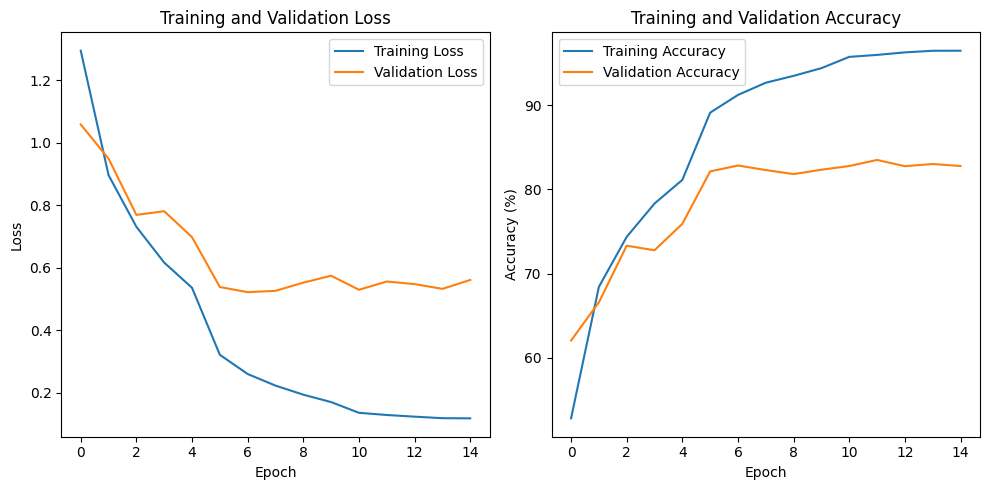

In [20]:
train_and_validate(model, train_loader2, valid_loader2, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Seventh Layer CSI - train

100%|██████████| 40/40 [00:01<00:00, 27.56it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2948.20it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2942.68it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2954.43it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2950.27it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2089.49it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3203.39it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2953.04it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3223.08it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3072.75it/s]

[('layer1', 0.41679999232292175), ('layer2', 0.4991999864578247), ('layer3', 0.5637999773025513), ('layer4', 0.6301999688148499), ('layer5', 0.6967999935150146), ('layer6', 0.7799999713897705), ('layer7', 0.8227999806404114), ('fc1', 0.824999988079071), ('fc2', 0.8139999508857727)]


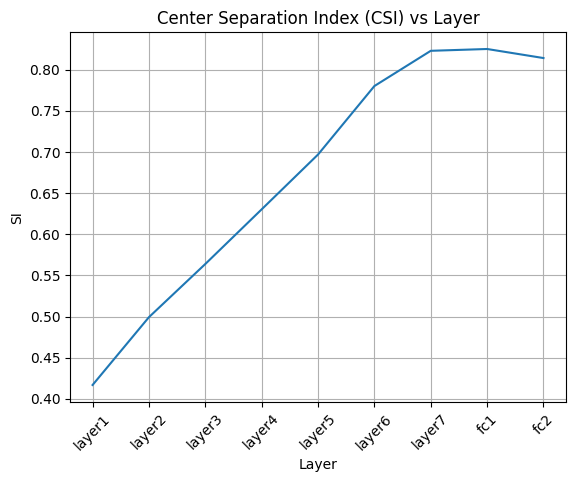

[('layer1', 0.41679999232292175), ('layer2', 0.4991999864578247), ('layer3', 0.5637999773025513), ('layer4', 0.6301999688148499), ('layer5', 0.6967999935150146), ('layer6', 0.7799999713897705), ('layer7', 0.8227999806404114), ('fc1', 0.824999988079071), ('fc2', 0.8139999508857727)]


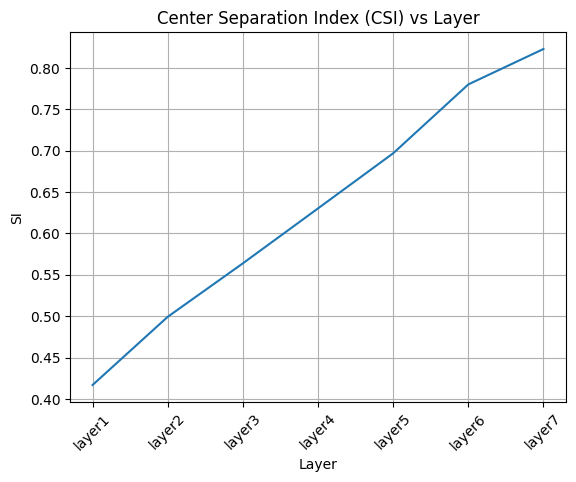

In [44]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_seven_layer().to(device)
model.load_state_dict(torch.load('seventh_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI2): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()   


print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Seventh Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 56.99it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4035.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4019.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4170.12it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 3896.60it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 2998.07it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4194.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4072.14it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4150.31it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4241.81it/s]


[('layer1', 0.41290000081062317), ('layer2', 0.5037999749183655), ('layer3', 0.5733000040054321), ('layer4', 0.6437000036239624), ('layer5', 0.7130999565124512), ('layer6', 0.784500002861023), ('layer7', 0.8303999900817871), ('fc1', 0.8341999650001526), ('fc2', 0.8208000063896179)]


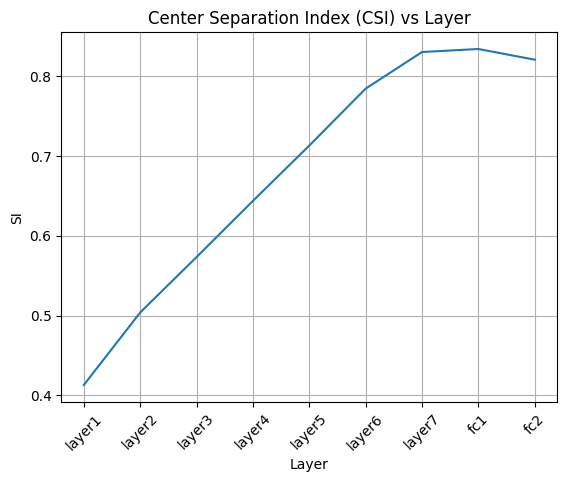

[('layer1', 0.41290000081062317), ('layer2', 0.5037999749183655), ('layer3', 0.5733000040054321), ('layer4', 0.6437000036239624), ('layer5', 0.7130999565124512), ('layer6', 0.784500002861023), ('layer7', 0.8303999900817871), ('fc1', 0.8341999650001526), ('fc2', 0.8208000063896179)]


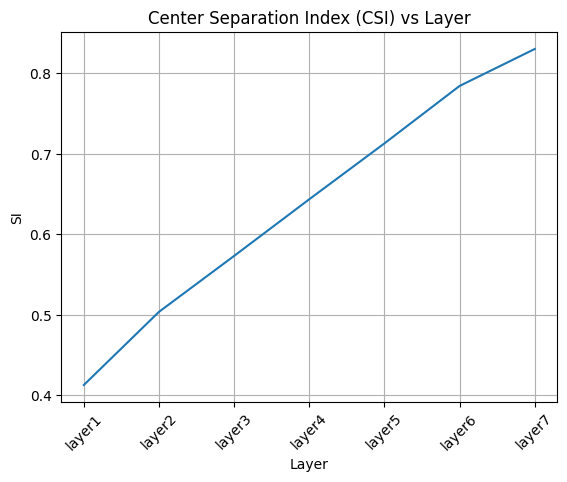

In [45]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_seven_layer().to(device)
model.load_state_dict(torch.load('seventh_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()   


print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Eighth Layer

In [46]:
import torch.nn as nn

class VGG11_eighth_layer(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG11_eighth_layer, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.layer8 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(512, 512)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [47]:
import torch
import torch.nn as nn


model = VGG11_eighth_layer().to(device)

model

VGG11_eighth_layer(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats

  7%|▋         | 1/15 [00:26<06:04, 26.02s/it]

Epoch [1/15], Step [352/352], Training Loss: 1.2894, Training Accuracy: 53.50%, Validation Accuracy: 62.24%, Validation Loss: 1.0307


 13%|█▎        | 2/15 [00:49<05:16, 24.35s/it]

Epoch [2/15], Step [352/352], Training Loss: 0.9025, Training Accuracy: 68.18%, Validation Accuracy: 69.00%, Validation Loss: 0.8772


 20%|██        | 3/15 [01:11<04:42, 23.53s/it]

Epoch [3/15], Step [352/352], Training Loss: 0.7356, Training Accuracy: 73.97%, Validation Accuracy: 69.46%, Validation Loss: 0.8771


 27%|██▋       | 4/15 [01:34<04:16, 23.31s/it]

Epoch [4/15], Step [352/352], Training Loss: 0.6279, Training Accuracy: 78.02%, Validation Accuracy: 74.66%, Validation Loss: 0.7130


 33%|███▎      | 5/15 [01:57<03:51, 23.16s/it]

Epoch [5/15], Step [352/352], Training Loss: 0.5478, Training Accuracy: 80.74%, Validation Accuracy: 75.70%, Validation Loss: 0.7051


 40%|████      | 6/15 [02:20<03:28, 23.20s/it]

Epoch [6/15], Step [352/352], Training Loss: 0.3282, Training Accuracy: 88.88%, Validation Accuracy: 81.66%, Validation Loss: 0.5539


 47%|████▋     | 7/15 [02:43<03:04, 23.08s/it]

Epoch [7/15], Step [352/352], Training Loss: 0.2662, Training Accuracy: 90.99%, Validation Accuracy: 82.12%, Validation Loss: 0.5386


 53%|█████▎    | 8/15 [03:06<02:40, 22.86s/it]

Epoch [8/15], Step [352/352], Training Loss: 0.2277, Training Accuracy: 92.36%, Validation Accuracy: 81.84%, Validation Loss: 0.5525


 60%|██████    | 9/15 [03:29<02:17, 22.90s/it]

Epoch [9/15], Step [352/352], Training Loss: 0.2014, Training Accuracy: 93.11%, Validation Accuracy: 82.30%, Validation Loss: 0.5798


 67%|██████▋   | 10/15 [03:52<01:54, 22.96s/it]

Epoch [10/15], Step [352/352], Training Loss: 0.1713, Training Accuracy: 94.18%, Validation Accuracy: 82.54%, Validation Loss: 0.5869


 73%|███████▎  | 11/15 [04:15<01:32, 23.06s/it]

Epoch [11/15], Step [352/352], Training Loss: 0.1310, Training Accuracy: 95.84%, Validation Accuracy: 82.66%, Validation Loss: 0.5514


 80%|████████  | 12/15 [04:37<01:08, 22.74s/it]

Epoch [12/15], Step [352/352], Training Loss: 0.1224, Training Accuracy: 96.20%, Validation Accuracy: 82.02%, Validation Loss: 0.5920


 87%|████████▋ | 13/15 [05:00<00:45, 22.75s/it]

Epoch [13/15], Step [352/352], Training Loss: 0.1178, Training Accuracy: 96.27%, Validation Accuracy: 82.62%, Validation Loss: 0.5634


 93%|█████████▎| 14/15 [05:23<00:22, 22.89s/it]

Epoch [14/15], Step [352/352], Training Loss: 0.1145, Training Accuracy: 96.46%, Validation Accuracy: 82.88%, Validation Loss: 0.5835


100%|██████████| 15/15 [05:46<00:00, 23.09s/it]

Epoch [15/15], Step [352/352], Training Loss: 0.1102, Training Accuracy: 96.61%, Validation Accuracy: 83.30%, Validation Loss: 0.5978


Test Set Accuracy on Best Weights: 84.02%


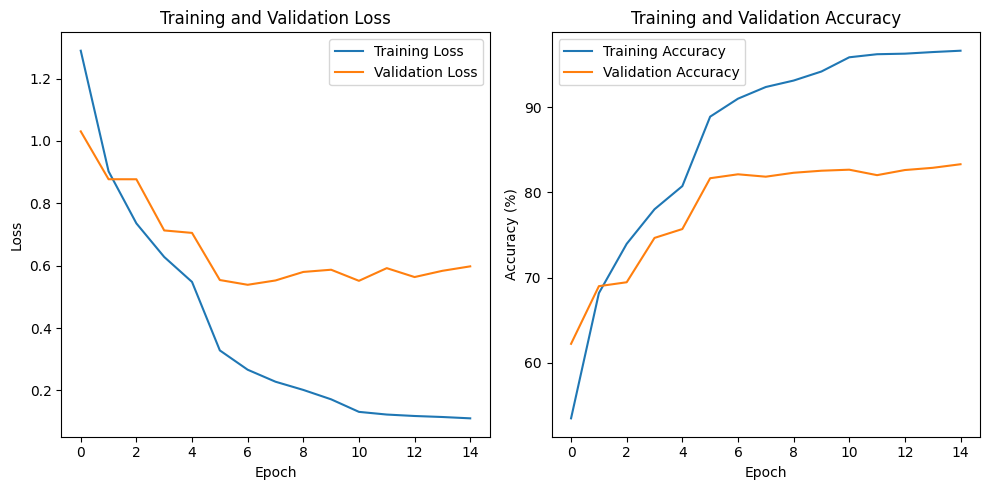

In [23]:
train_and_validate(model, train_loader2, valid_loader2, test_loader, num_epochs=15, early_stopping_threshold=10, device='cuda:0')

# Eighth Layer CSI - train

100%|██████████| 40/40 [00:01<00:00, 39.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2986.69it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3003.80it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3028.38it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3043.03it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 1954.78it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 2982.44it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3158.36it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3235.51it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3034.22it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 3/3 [00:00<00:00, 3305.20it/s]

[('layer1', 0.4081999957561493), ('layer2', 0.4941999912261963), ('layer3', 0.5740000009536743), ('layer4', 0.6313999891281128), ('layer5', 0.6937999725341797), ('layer6', 0.7662000060081482), ('layer7', 0.8173999786376953), ('layer8', 0.8203999996185303), ('fc1', 0.8203999996185303), ('fc2', 0.8163999915122986)]


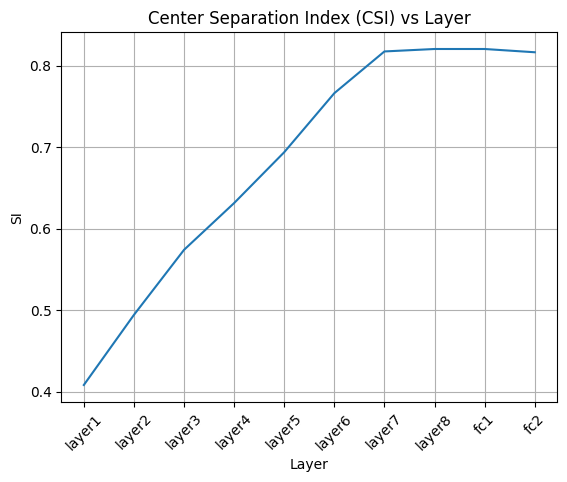

[('layer1', 0.4081999957561493), ('layer2', 0.4941999912261963), ('layer3', 0.5740000009536743), ('layer4', 0.6313999891281128), ('layer5', 0.6937999725341797), ('layer6', 0.7662000060081482), ('layer7', 0.8173999786376953), ('layer8', 0.8203999996185303), ('fc1', 0.8203999996185303), ('fc2', 0.8163999915122986)]


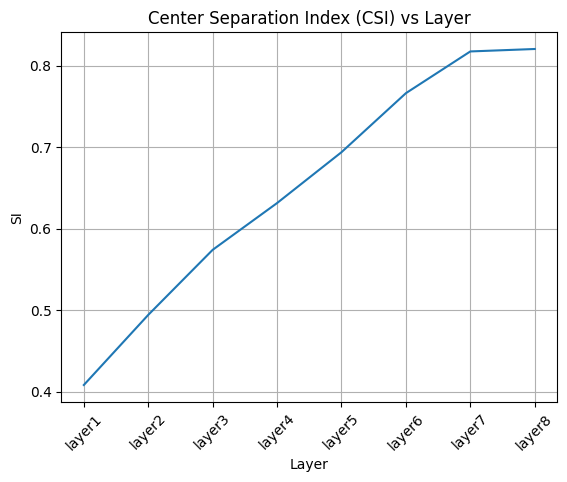

In [48]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_eighth_layer().to(device)
model.load_state_dict(torch.load('eighth_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(train_loader_SI2): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Eighth Layer CSI - test

100%|██████████| 79/79 [00:01<00:00, 57.83it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4185.10it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4659.30it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4142.93it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4080.06it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4566.97it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4453.50it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4158.54it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4359.98it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4259.91it/s]


Data has been normalized


Calculating CSI: 100%|██████████| 5/5 [00:00<00:00, 4452.55it/s]

[('layer1', 0.41040000319480896), ('layer2', 0.5036999583244324), ('layer3', 0.5777999758720398), ('layer4', 0.6446999907493591), ('layer5', 0.7026999592781067), ('layer6', 0.7667999863624573), ('layer7', 0.8246999979019165), ('layer8', 0.8264999985694885), ('fc1', 0.8346999883651733), ('fc2', 0.824400007724762)]


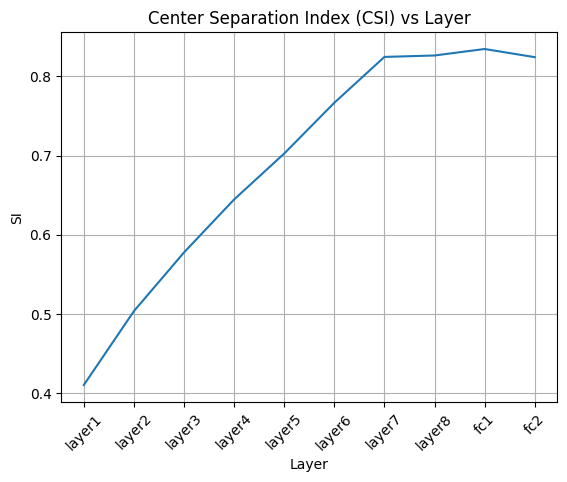

[('layer1', 0.41040000319480896), ('layer2', 0.5036999583244324), ('layer3', 0.5777999758720398), ('layer4', 0.6446999907493591), ('layer5', 0.7026999592781067), ('layer6', 0.7667999863624573), ('layer7', 0.8246999979019165), ('layer8', 0.8264999985694885), ('fc1', 0.8346999883651733), ('fc2', 0.824400007724762)]


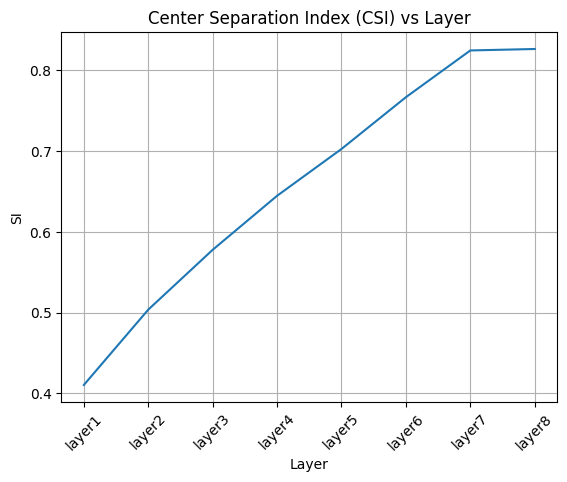

In [49]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = VGG11_eighth_layer().to(device)
model.load_state_dict(torch.load('eighth_layer_dal.pth'))
model.to('cuda:1' if torch.cuda.is_available() else 'cpu')
model.eval()

# Prepare storage for outputs and labels
features_per_layer = {}
labels_list = []

# Define layers to exclude
exclude_layers = {'' }

# Function to attach hooks
def get_layer_outputs(layer_name):
    def hook(module, input, output):
        features_per_layer[layer_name].append(output.detach())
    return hook

# Attach hooks to each layer except the excluded ones
for name, layer in model.named_children():
    if name not in exclude_layers:
        features_per_layer[name] = []
        layer.register_forward_hook(get_layer_outputs(name))

# Pass data through the model and collect layer outputs
with torch.no_grad():
    for inputs, targets in tqdm(test_loader): 
        inputs = inputs.to('cuda:1' if torch.cuda.is_available() else 'cpu')

        # Trigger the hooks and collect layer outputs
        model(inputs)
        labels_list.append(targets.cpu())

        # Clear CUDA cache after processing each batch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

# Post-process the data: Flatten and concatenate
for layer_name, layer_features in features_per_layer.items():
    if layer_features:  # Check if layer_features is not empty
        try:
            features_per_layer[layer_name] = torch.cat([f.view(f.size(0), -1) for f in layer_features])
        except RuntimeError as e:
            print(f"Error in concatenating features of layer {layer_name}")
            for f in layer_features:
                print(f.shape)
            raise e
# Concatenate the labels
labels = torch.cat(labels_list)

csi_layer_train = []

# Iterate through each layer's features in the dictionary
for layer_name, features in features_per_layer.items():
    instance_disturbance = ARH_SeparationIndex(features, labels, normalize=True)
    csi = instance_disturbance.center_si_batch(batch_size=2000)
    csi_layer_train.append((layer_name, csi))

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train], [si for _, si in csi_layer_train])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()    

print(csi_layer_train)


# Plotting SI versus layer using a line plot
plt.plot([layer for layer, _ in csi_layer_train[0:-2]], [si for _, si in csi_layer_train[0:-2]])
plt.xlabel('Layer')
plt.ylabel('SI')
plt.title('Center Separation Index (CSI) vs Layer')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()